In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [6]:
df=pd.read_csv('Historical Product Demand.csv')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [8]:
df["Order_Demand"] = pd.to_numeric(df.Order_Demand, errors='coerce')
df = df.dropna(subset=['Order_Demand'])

In [10]:
#Create year, quarter, month and day features
df['Date']=pd.to_datetime(df['Date']) 
df['year'] = df['Date'].apply(lambda x: x.year)
df['quarter'] = df['Date'].apply(lambda x: x.quarter)
df['month'] = df['Date'].apply(lambda x: x.month)
df['day'] = df['Date'].apply(lambda x: x.day)
df=df.loc[:,['Date','Order_Demand', 'year','quarter','month','day']]

In [11]:
#Create weekday feature, “0” is weekend and “1” is weekday
df.sort_values('Date', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["Date"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [12]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.Date.min())
print('The time series ends on: ', df.Date.max())

Number of rows and columns after removing missing values: (1038106, 7)
The time series starts from:  2011-01-08 00:00:00
The time series ends on:  2017-01-09 00:00:00


In [13]:
#statistical normality test
stat, p = stats.normaltest(df.Order_Demand)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=2753218.008, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 1869.9609760279902
Skewness of normal distribution: 31.515733813921987


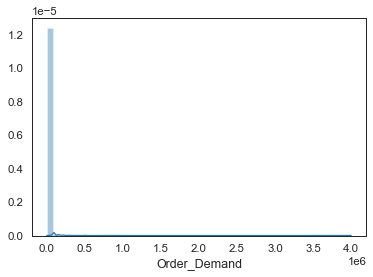

In [14]:
#calculate kurtosis and skewness to determine if the data distribution departs from the normal distribution
sns.distplot(df.Order_Demand);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Order_Demand)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Order_Demand)))

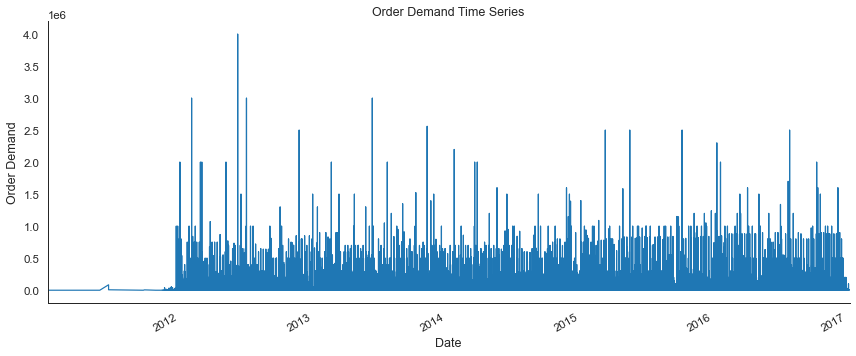

In [15]:
#time seires plot
df1=df.loc[:,['Date','Order_Demand']]
df1.set_index('Date',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Order Demand')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Order Demand Time Series')
sns.despine(top=True)
plt.show();

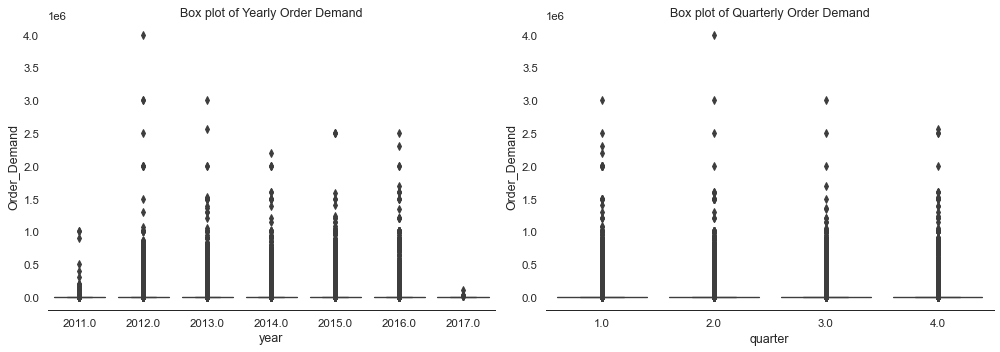

In [16]:
#box plot
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Order_Demand", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Order Demand')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Order_Demand", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Order Demand')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
Order_Demand,1038106.0000,4936.4880,29024.6241,0.0000,20.0000,300.0000,2000.0000,4000000.0000


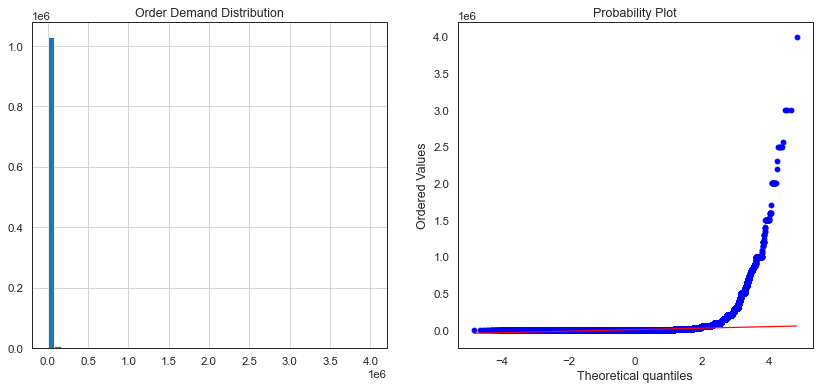

In [17]:
#order demand distribution
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Order_Demand'].hist(bins=50)
plt.title('Order Demand Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Order_Demand'], plot=plt);
df1.describe().T

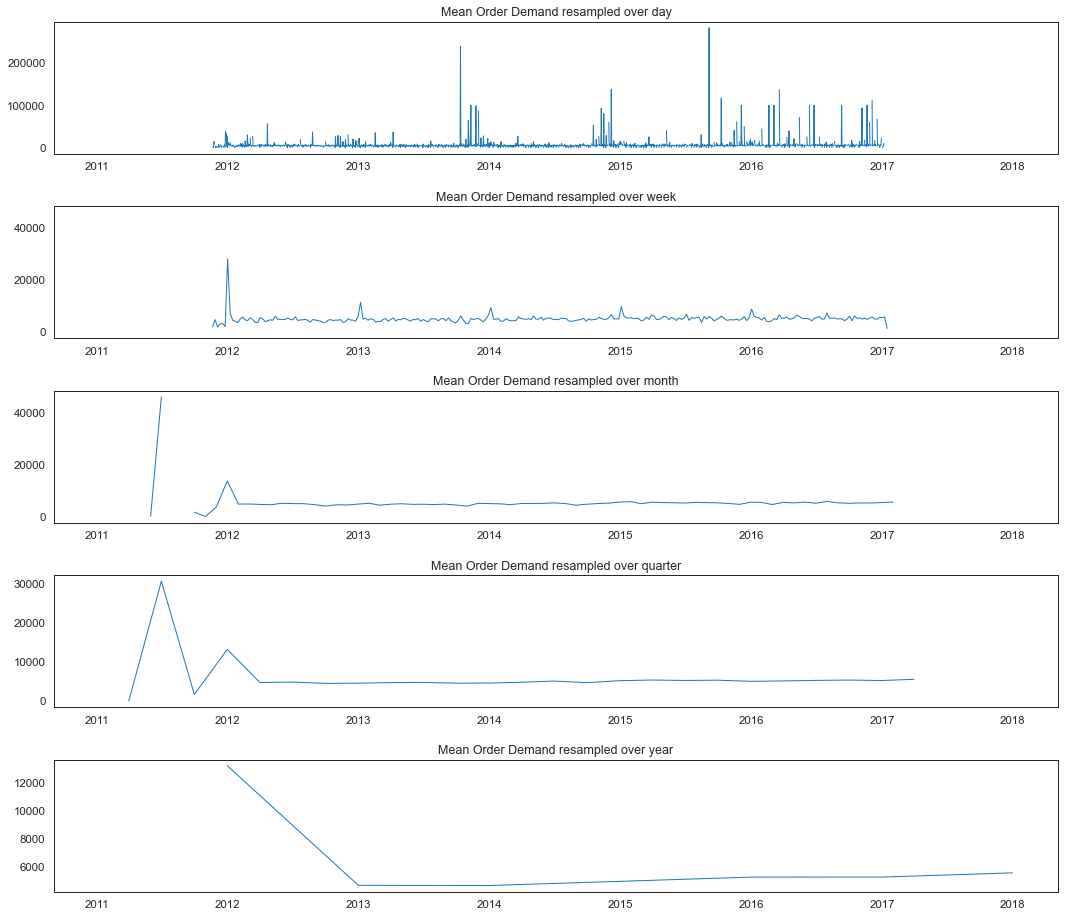

In [18]:
#average order demand
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Order_Demand'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Order Demand resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Order_Demand'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Order Demand resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Order_Demand'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Order Demand resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Order_Demand'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Order Demand resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Order_Demand'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Order Demand resampled over year')
ax5.tick_params(axis='both', which='major');

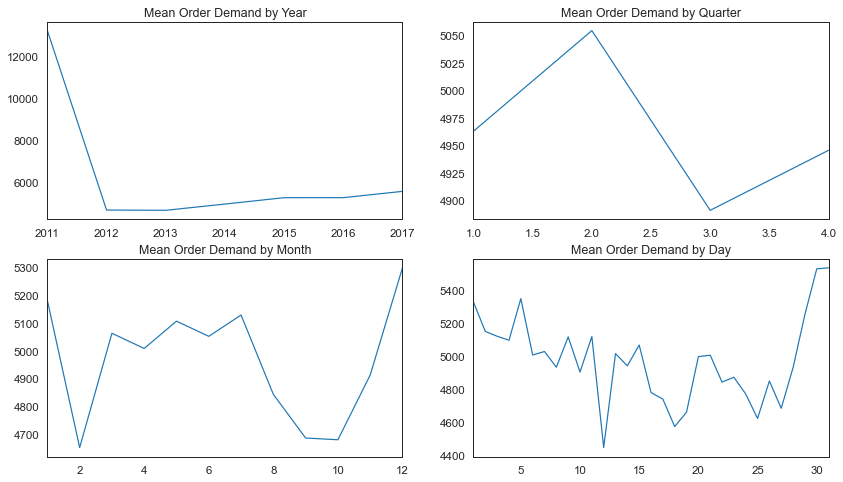

In [19]:
#mean order demand
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Order_Demand.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Order Demand by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Order_Demand.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Order Demand by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Order_Demand.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Order Demand by Month')

plt.subplot(2,2,4)
df.groupby('day').Order_Demand.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Order Demand by Day');

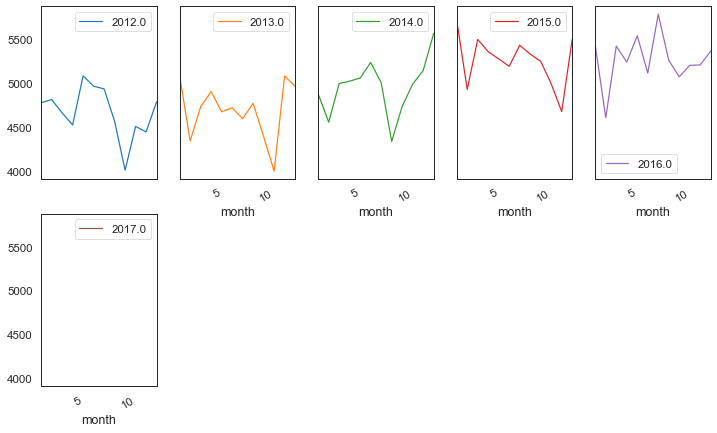

In [22]:
#order demand by years
pd.pivot_table(df.loc[df['year'] != 2011], values = "Order_Demand", columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

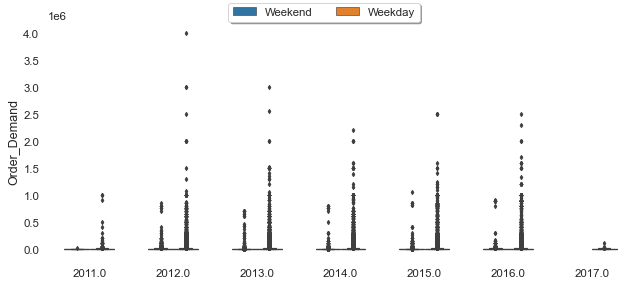

In [23]:
#demand prediction in weekdays vs. weekends
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Order_Demand',hue='Day',width=0.6,fliersize=3,data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

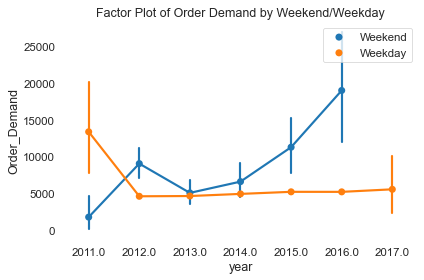

In [24]:
#factor plot
plt1=sns.factorplot('year','Order_Demand',hue='Day',data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Order Demand by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

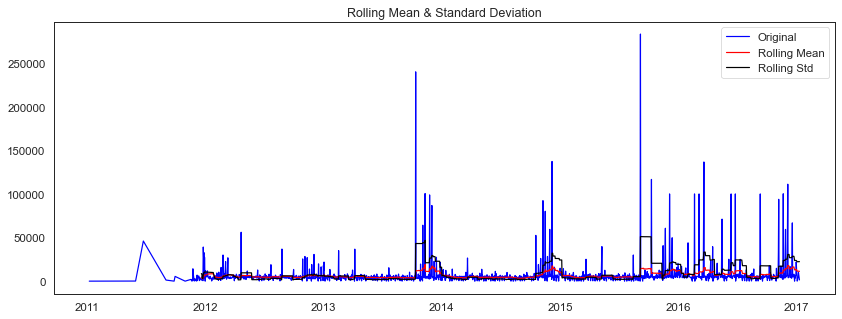

<Results of Dickey-Fuller Test>
Test Statistic                  -9.3555
p-value                          0.0000
#Lags Used                      12.0000
Number of Observations Used   1714.0000
Critical Value (1%)             -3.4342
Critical Value (5%)             -2.8632
Critical Value (10%)            -2.5677
dtype: float64


In [25]:
#dickey-fuller test
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Order_Demand.dropna())

In [26]:
#LSTM
dataset = df.Order_Demand.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [27]:
#model architecture
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 830453 samples, validate on 207591 samples
Epoch 1/20
830453/830453 [==============================] - 52s 62us/step - loss: 5.1917e-05 - val_loss: 5.7446e-05
Epoch 2/20
830453/830453 [==============================] - 47s 56us/step - loss: 5.1734e-05 - val_loss: 5.7452e-05
Epoch 3/20
830453/830453 [==============================] - 47s 56us/step - loss: 5.1705e-05 - val_loss: 5.7465e-05
Epoch 4/20
830453/830453 [==============================] - 49s 59us/step - loss: 5.1688e-05 - val_loss: 5.7467e-05
Epoch 5/20
830453/830453 [==============================] - 51s 62us/step - loss: 5.1669e-05 - val_loss: 5.7487e-05
Epoch 6/20
830453/830453 [==============================] - 47s 57us/step - loss: 5.1702e-05 - val_loss: 5.7449e-05
Epoch 7/20
830453/830453 [==============================] - 48s 58us/step - loss: 5.1664e-05 - val_loss: 5.7479e-05
Epoch 8/20
83045

In [28]:
#make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 7193.743809305767
Train Root Mean Squared Error: 28609.149568080073
Test Mean Absolute Error: 7422.553122279273
Test Root Mean Squared Error: 30329.102519444896


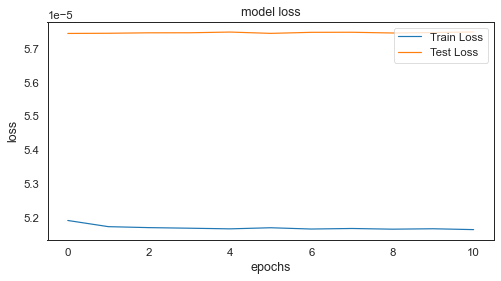

In [29]:
#plot model loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

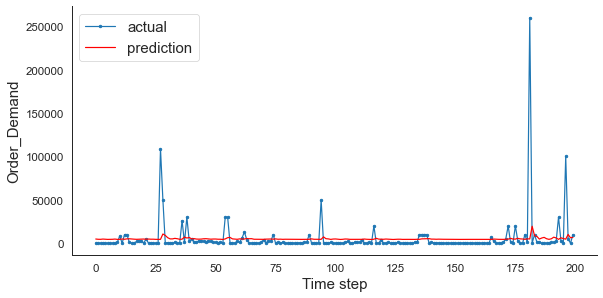

In [30]:
#compare actual vs prediction
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Order_Demand', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();